#### Features highly correlated with NHY feature:
* NP3FACXP, NP3FTAPR, NP3HMOVR, NP3PRSPR, NP3TTAPR,NP3POSTR, NP3BRADY,NP2TMPR,NP3SPCH,MSEADLG

## 0. Imports & functions

In [4]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
% matplotlib inline

import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import sklearn.cross_validation as cv
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# I. Features importance & Non TS classification of Disease Progression

## 1. Data preparation

In [11]:
file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df=pd.read_csv(file_path)
df.drop(columns='Unnamed: 0',inplace=True)
df.drop(columns=['EVENT_ID','INFODT'],inplace=True)
df.loc[df['MSEADLG']==10.0,'MSEADLG']=45.0
df.loc[df['MSEADLG']==20.0,'MSEADLG']=45.0
df.loc[df['MSEADLG']==30.0,'MSEADLG']=45.0
df.loc[df['MSEADLG']==35.0,'MSEADLG']=45.0
df.loc[df['MSEADLG']==40.0,'MSEADLG']=45.0
#df.loc[df['MSEADLG']==.0,'MSEADLG']=50.0
print(set(df['MSEADLG']))
df.head()

{65.0, 100.0, 70.0, 75.0, 45.0, 80.0, 50.0, 85.0, 55.0, 90.0, 60.0, 95.0}


,PATNO,INFODT_date,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,2011-02-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,1,0,2707,306,0,0
1,3001,2012-03-01,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,2,7,2,394,2313,700,0,0
2,3001,2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,2,7,3,426,1887,1126,0,0
3,3001,2014-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,4,335,1552,1461,0,0
4,3001,2015-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,5,365,1187,1826,0,0


In [12]:
dfAgg=df.groupby('PATNO').agg('median')
dfAgg.drop(columns=['visitsdiff_days','VISIT_ID'],inplace=True)
dfAgg.drop(columns='NHY',inplace=True)
dfAgg['MSEADLG']=dfAgg['MSEADLG'].apply(lambda x: round(x,0))
print(set(dfAgg['MSEADLG']))
dfAgg.head()

{45.0, 48.0, 50.0, 55.0, 58.0, 60.0, 62.0, 65.0, 68.0, 70.0, 72.0, 75.0, 78.0, 80.0, 82.0, 85.0, 88.0, 90.0, 92.0, 95.0, 98.0, 100.0}


,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,7.0,1552.0,1461.0,0.0,0.0
3002,1.0,0.0,1.0,1.0,0.0,0.0,1.5,2.5,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,6.0,1567.5,1504.5,0.0,0.0
3003,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,7.0,1552.0,1857.0,0.0,0.0
3006,0.0,0.0,0.5,1.0,0.0,0.0,2.5,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,2.0,2.0,2465.5,333.5,0.0,0.0
3007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,...,1.0,1.0,0.0,1.0,2.0,1.0,2648.0,90.0,0.0,0.0


In [14]:
dfAgg.loc[dfAgg['MSEADLG']==48.0,'MSEADLG']=45.0
dfAgg.loc[dfAgg['MSEADLG']==58.0,'MSEADLG']=60.0
dfAgg.loc[dfAgg['MSEADLG']==62.0,'MSEADLG']=60.0
dfAgg.loc[dfAgg['MSEADLG']==68.0,'MSEADLG']=70.0
dfAgg.loc[dfAgg['MSEADLG']==72.0,'MSEADLG']=70.0
dfAgg.loc[dfAgg['MSEADLG']==78.0,'MSEADLG']=80.0
dfAgg.loc[dfAgg['MSEADLG']==82.0,'MSEADLG']=80.0
dfAgg.loc[dfAgg['MSEADLG']==88.0,'MSEADLG']=90.0
dfAgg.loc[dfAgg['MSEADLG']==92.0,'MSEADLG']=90.0
dfAgg.loc[dfAgg['MSEADLG']==98.0,'MSEADLG']=100.0
print(list(set(dfAgg['MSEADLG'])))
dfAgg['MSEADLG'].value_counts()

[65.0, 100.0, 70.0, 75.0, 45.0, 80.0, 50.0, 85.0, 55.0, 90.0, 60.0, 95.0]


100.0    850
90.0     421
80.0     143
95.0     103
85.0      46
70.0      36
60.0      21
45.0      15
65.0      12
75.0      12
50.0      11
55.0       4
Name: MSEADLG, dtype: int64

## 2. Split train, test

In [16]:
from sklearn.model_selection import train_test_split
data=dfAgg.drop(columns='MSEADLG')
target=dfAgg['MSEADLG']
X_train, X_test,y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)
print('train counts: {}'.format(y_train.value_counts()))
print(X_train.shape)
print(X_test.shape)
print('test counts: {}'.format(y_test.value_counts()))
X_train.head()

train counts: 100.0    685
90.0     324
80.0     114
95.0      80
85.0      41
70.0      31
60.0      18
45.0      12
75.0      10
65.0      10
50.0      10
55.0       4
Name: MSEADLG, dtype: int64
(1339, 370)
(335, 370)
test counts: 100.0    165
90.0      97
80.0      29
95.0      23
70.0       5
85.0       5
45.0       3
60.0       3
65.0       2
75.0       2
50.0       1
Name: MSEADLG, dtype: int64


,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3608,1.0,1.0,1.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,2.0,2282.5,1034.5,0.0,0.0
3909,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,2068.0,31.0,0.0,0.0
4003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,2557.0,607.0,0.0,0.0
52062,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,3.0,577.0,1065.0,0.0,0.0
40240,0.0,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,2.0,1261.5,3516.5,0.0,0.0


### Take care of the classes unbalance

In [17]:
from sklearn.utils import resample
train=pd.concat([X_train,y_train],axis=1)
train_majority = train[train.MSEADLG==100.0]
train_minority_1 = train[train.MSEADLG==95.0]
train_minority_2= train[train.MSEADLG==90.0]
train_minority_3= train[train.MSEADLG==85.0]
train_minority_4=train[train.MSEADLG==80.0]
train_minority_5=train[train.MSEADLG==75.0]
train_minority_6=train[train.MSEADLG==70.0]
train_minority_7=train[train.MSEADLG==65.0]
train_minority_8=train[train.MSEADLG==60.0]
train_minority_9=train[train.MSEADLG==55.0]
train_minority_10=train[train.MSEADLG==50.0]
train_minority_11=train[train.MSEADLG==45.0]

# Upsample minority class
train_minority_upsampled_1 = resample(train_minority_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_2 = resample(train_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_3 = resample(train_minority_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_4= resample(train_minority_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_5= resample(train_minority_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_6= resample(train_minority_6, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_7= resample(train_minority_7, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_8= resample(train_minority_8, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_9= resample(train_minority_9, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_10= resample(train_minority_10, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_11= resample(train_minority_11, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results



# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled_1,train_minority_upsampled_2,
                             train_minority_upsampled_3,train_minority_upsampled_4,
                             train_minority_upsampled_5,train_minority_upsampled_6,
                            train_minority_upsampled_7,train_minority_upsampled_8,
                            train_minority_upsampled_9, train_minority_upsampled_10,
                            train_minority_upsampled_11])

# Show new class counts
train_upsampled.MSEADLG.value_counts()

55.0     685
85.0     685
90.0     685
65.0     685
60.0     685
95.0     685
70.0     685
45.0     685
50.0     685
75.0     685
80.0     685
100.0    685
Name: MSEADLG, dtype: int64

In [18]:
X_train_up = train_upsampled.loc[:,train.columns!='MSEADLG']
y_train_up= train_upsampled['MSEADLG']

`from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
X_resampled.shape
logreg_smote = LogisticRegression(random_state=0).fit(X_resampled, y_resampled)`

In [17]:
#X_resampled, y_resampled = ADASYN().fit_sample(X, y)
#clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)

## 3. Model Training

### Dummy Classifier

In [12]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
logreg_up=LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=1)
logreg_up.fit(X_train_up, y_train_up)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

### Random Forest

In [22]:
rfc_up = RandomForestClassifier(n_estimators=100, random_state=1)
rfc_up.fit(X_train_up, y_train_up)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [26]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### XGBoost

In [21]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs=-1,seed=0)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [22]:
xgb_up=XGBClassifier(n_jobs=-1,seed=0)
xgb_up.fit(X_train_up, y_train_up)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

### feature importance
do a pairplot of the important features in the original dataset

## 4. Evaluation: Calculating, plotting metrics

In [13]:
print("Train-Score: %.4f, Test-Accuracy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

Train-Score: 0.3484, Test-Accuracy: 0.3419


In [18]:
print("Train-Score-logreg: %.4f, Test-Accuracy-logreg: %.4f" % (logreg.score(X_train, y_train), logreg.score(X_test, y_test)))
print("Train-Score-logreg-up: %.4f, Test-Accuracy-logreg-up: %.4f" % (logreg_up.score(X_train_up, y_train_up), 
                                                                      logreg_up.score(X_test, y_test)))
print("Train-Score-rfc: %.4f, Test-Accuracy-rfc: %.4f" % (rfc.score(X_train, y_train), rfc.score(X_test, y_test)))
print("Train-Score-rfc-up: %.4f, Test-Accuracy-rfc: %.4f" % (rfc_up.score(X_train_up, y_train_up), rfc_up.score(X_test, y_test)))
print("Train-score-xgb: %.2f%%, Test-score-xgb: %.2f%%" % (100. * xgb.score(X_train, y_train), 
                                                         100. * xgb.score(X_test, y_test)))

Train-Score-logreg: 0.8719, Test-Accuracy-logreg: 0.6402


### Confusion Matrix

(15, 15)


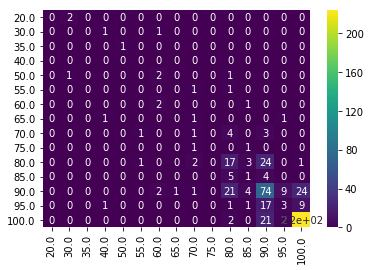

In [28]:
y_pred_logreg=logreg.predict(X_test)
cm_logreg=confusion_matrix(y_test,y_pred_logreg)
index_cm=[65.0, 35.0, 100.0, 70.0, 40.0, 75.0, 80.0, 
          50.0, 20.0, 85.0, 55.0, 90.0, 60.0, 30.0, 95.0]
index_cm.sort()
print(cm_logreg.shape)
cm_logreg_df=pd.DataFrame(cm_logreg,index=index_cm,columns=index_cm)
import seaborn as sns
sns.heatmap(cm_logreg_df,annot=True,cmap='viridis')

[ 60.  70.  80.  90.  95. 100.]
[ 20.  30.  35.  50.  55.  60.  65.  70.  75.  80.  85.  90.  95. 100.]


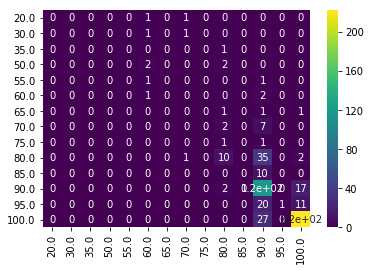

In [39]:
y_pred_rfc=rfc.predict(X_test)
cm_rfc=confusion_matrix(y_test,y_pred_rfc)
print(np.unique(y_pred_rfc))
print(np.unique(y_test))
#index_cm.remove(40.0)
cm_rfc_df=pd.DataFrame(cm_rfc,index=index_cm,columns=index_cm)
sns.heatmap(cm_rfc_df,annot=True,cmap='viridis')

### classification report

In [40]:
from sklearn.metrics import classification_report
report_logreg = classification_report(y_test, 
                      y_pred_logreg)
print(report_logreg)

             precision    recall  f1-score   support

       20.0       0.00      0.00      0.00         2
       30.0       0.00      0.00      0.00         2
       35.0       0.00      0.00      0.00         1
       40.0       0.00      0.00      0.00         0
       50.0       0.00      0.00      0.00         4
       55.0       0.00      0.00      0.00         2
       60.0       0.29      0.67      0.40         3
       65.0       0.00      0.00      0.00         3
       70.0       0.14      0.11      0.12         9
       75.0       0.00      0.00      0.00         2
       80.0       0.33      0.35      0.34        48
       85.0       0.09      0.10      0.10        10
       90.0       0.52      0.54      0.53       136
       95.0       0.20      0.09      0.13        32
      100.0       0.87      0.90      0.88       249

avg / total       0.62      0.64      0.63       503



In [41]:
report_rfc = classification_report(y_test, 
                      y_pred_rfc)
print(report_rfc)

             precision    recall  f1-score   support

       20.0       0.00      0.00      0.00         2
       30.0       0.00      0.00      0.00         2
       35.0       0.00      0.00      0.00         1
       50.0       0.00      0.00      0.00         4
       55.0       0.00      0.00      0.00         2
       60.0       0.17      0.33      0.22         3
       65.0       0.00      0.00      0.00         3
       70.0       0.00      0.00      0.00         9
       75.0       0.00      0.00      0.00         2
       80.0       0.53      0.21      0.30        48
       85.0       0.00      0.00      0.00        10
       90.0       0.53      0.86      0.66       136
       95.0       1.00      0.03      0.06        32
      100.0       0.88      0.89      0.88       249

avg / total       0.69      0.70      0.65       503



In [31]:
y_pred_rfc_up=rfc_up.predict(X_test)
report_rfc_up = classification_report(y_test, 
                      y_pred_rfc_up)
print(report_rfc_up)

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       205
        1.0       0.73      0.68      0.70        56
        2.0       0.89      0.93      0.91       217
        3.0       0.50      0.33      0.40        18
        4.0       0.50      0.17      0.25         6
        5.0       0.00      0.00      0.00         1

avg / total       0.88      0.89      0.89       503



In [17]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures=feature_importances[feature_importances.values>=0.01]
print(sum(ImportantFeatures.values))
ImportantFeatures

[0.33840233]


,importance
PDDXDT_diff_days,0.034118
NP3BRADY,0.026388
DOMSIDE,0.025719
PD_MED_USE,0.018252
NP3FACXP,0.016513
NP2DRES,0.015723
DFRIGIDP,0.015037
NP3GAIT,0.014356
PRIMDIAG,0.014240
NP2RISE,0.013401


In [1]:
#feature_importances_up = pd.DataFrame(rfc_up.feature_importances_,
                                   #index = X_train.columns,
                                    #columns=['importance']).sort_values('importance',ascending=False)
#ImportantFeatures_up=feature_importances_up[feature_importances.values>=0.01]
#ImportantFeatures_up

In [28]:
def plot_feature_importances(rf, cols):
    importances = pd.DataFrame()
    importances.loc[:, 'importances'] = rf.feature_importances_
    importances.loc[:, 'features'] = cols
    importances.sort_values('importances', inplace=True)
    return plt.plot(importances, 'features', 'importances', kind='barh', color='b')

In [30]:
#plot_feature_importances(rfc,X_train.columns)
## correct error.

## 5. Cross-Validation

In [71]:
from sklearn.cross_validation import LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score
cv_score=cross_val_score(logreg,data,target,cv=3,n_jobs=-1)
print(cv_score)
print(cv_score.mean())

Process ForkPoolWorker-18:
Process ForkPoolWorker-19:
Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

In [43]:
from sklearn.model_selection import cross_val_score
cv_score_rfc=cross_val_score(rfc,data,target,cv=5,n_jobs=-1)
print(cv_score_rfc)
print(cv_score_rfc.mean())

[0.44897959 0.61127596 0.66467066 0.64954683 0.6443769 ]
0.6037699884803344


## 6. Hyperparameter tuning with GridSearchCV

In [36]:
#param_grid_rfc={'n_estimators':[5,10,15,20],
               #'max_features':[5,10,15,20,50,100],
               #'max_depth':[None,5,15,25,50],
               #'max_leaf_nodes':[None,25,50,100,200],
               #'min_samples_leaf':[1,5,10,15,20]}
param_grid_rfc={'n_estimators':[10,15,20],
               'max_features':[10,50,100],
               'max_leaf_nodes':[None,25,50,100]}
from sklearn.model_selection import GridSearchCV
grid_search=GridSearchCV(RandomForestClassifier(n_jobs=-1),param_grid_rfc,cv=5)

In [37]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15, 20], 'max_features': [10, 50, 100], 'max_leaf_nodes': [None, 25, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best parameters: {'max_features': 100, 'max_leaf_nodes': None, 'n_estimators': 15}
Best cross-validation score: 0.85


# II. Time-series prediction (input timestep=3)

In [44]:
def patients_selection(df, threshold=6):
    '''return a dataframe containing only the patients with number of visits > threshold'''
    if 'PATNO' in df.columns: 
        visits_number_by_pat=df.groupby('PATNO').size().sort_values(ascending=False)
        mask_sel=visits_number_by_pat>=threshold
        patients_sel=list(mask_sel[mask_sel.values==True].index)
        df=df.loc[df['PATNO'].isin(patients_sel),:]
        df=df.sort_values('PATNO')
        return (patients_sel, df)
    else:
        return 0

file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df2=pd.read_csv(file_path)
print(df2.shape)
df_th2=patients_selection(df,threshold=2)[1]
print(df_th2.shape)
df_th2['num_visits'].value_counts()

(4784, 379)
(4113, 376)


6    852
7    714
2    586
3    564
5    525
4    512
8    360
Name: num_visits, dtype: int64

### padding for patients with visits <4

In [45]:
rowstoAdd=df_th2[df_th2['num_visits']==2].groupby('PATNO').median()
rowstoAdd['VISIT_ID']=3
rowstoAdd['visitsdiff_days']=3*61
rowstoAdd['lastDate_diff_days']=rowstoAdd['lastDate_diff_days']-rowstoAdd['visitsdiff_days']
rowstoAdd['PDDXDT_diff_days']=rowstoAdd['PDDXDT_diff_days'].where(rowstoAdd['PDDXDT_diff_days']==0,
                                                                 rowstoAdd['PDDXDT_diff_days']+rowstoAdd['visitsdiff_days'])
maskMED=rowstoAdd['PDMEDT_diff_days']!=0
rowstoAdd.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd.loc[maskMED,'visitsdiff_days']
maskSURG=rowstoAdd['PDSURGDT_diff_days']!=0
rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd.loc[maskSURG,'visitsdiff_days']

rowstoAdd2=df_th2[df_th2['num_visits']==2].groupby('PATNO').median()
rowstoAdd2['VISIT_ID']=4
rowstoAdd2['visitsdiff_days']=3*61
rowstoAdd2['lastDate_diff_days']=rowstoAdd2['lastDate_diff_days']-rowstoAdd2['visitsdiff_days']
rowstoAdd2['PDDXDT_diff_days']=rowstoAdd2['PDDXDT_diff_days'].where(rowstoAdd2['PDDXDT_diff_days']==0,
                                                                 rowstoAdd2['PDDXDT_diff_days']+rowstoAdd2['visitsdiff_days'])

rowstoAdd2.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd2.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd2.loc[maskMED,'visitsdiff_days']
rowstoAdd2.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd2.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd2.loc[maskSURG,'visitsdiff_days']


rows3toAdd=df_th2[df_th2['num_visits']==3].groupby('PATNO').median()
rows3toAdd['VISIT_ID']=4
rows3toAdd['visitsdiff_days']=3*61
rows3toAdd['lastDate_diff_days']=rows3toAdd['lastDate_diff_days']-rows3toAdd['visitsdiff_days']
rows3toAdd['PDDXDT_diff_days']=rows3toAdd['PDDXDT_diff_days'].where(rows3toAdd['PDDXDT_diff_days']==0,
                                                                 rows3toAdd['PDDXDT_diff_days']+rows3toAdd['visitsdiff_days'])
mask3MED=rows3toAdd['PDMEDT_diff_days']!=0
rows3toAdd.loc[mask3MED,'PDMEDT_diff_days']=rows3toAdd.loc[mask3MED,'PDMEDT_diff_days']+rows3toAdd.loc[mask3MED,'visitsdiff_days']
mask3SURG=rows3toAdd['PDSURGDT_diff_days']!=0
rows3toAdd.loc[mask3SURG,'PDSURGDT_diff_days']=rows3toAdd.loc[mask3SURG,'PDSURGDT_diff_days']+rows3toAdd.loc[mask3SURG,'visitsdiff_days']

rowspadding=pd.concat([rowstoAdd,rowstoAdd2,rows3toAdd])
rowspadding['num_visits']=4
rowspadding.reset_index(inplace=True)
print(rowspadding.shape)
dfpad_th4=df_th2.drop(columns='INFODT_date')
print(dfpad_th4.shape)
dfpad_th4=pd.concat([dfpad_th4,rowspadding])
print(dfpad_th4.shape)
dfpad_th4['num_visits'].replace(2,4,inplace=True)
dfpad_th4['num_visits'].replace(3,4,inplace=True)
dfpad_th4.reset_index(drop=True,inplace=True)
print((len(rowstoAdd),len(rows3toAdd)))
dfpad_th4.head()

(774, 375)
(4113, 375)
(4887, 375)
(293, 188)


,PATNO,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,1,0,2707.0,306.0,0.0,0.0
1,3001,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,2,394,2313.0,700.0,0.0,0.0
2,3001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,3,426,1887.0,1126.0,0.0,0.0
3,3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,4,335,1552.0,1461.0,0.0,0.0
4,3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,7,5,365,1187.0,1826.0,0.0,0.0


In [51]:
dfpad_th4['MSEADLG']=dfpad_th4['MSEADLG'].apply(lambda x: round(x,0))
dfpad_th4.loc[dfpad_th4['MSEADLG']==62.0,'MSEADLG']=60.0
dfpad_th4.loc[dfpad_th4['MSEADLG']==68.0,'MSEADLG']=70.0
dfpad_th4.loc[dfpad_th4['MSEADLG']==72.0,'MSEADLG']=70.0
dfpad_th4.loc[dfpad_th4['MSEADLG']==82.0,'MSEADLG']=80.0
dfpad_th4.loc[dfpad_th4['MSEADLG']==88.0,'MSEADLG']=90.0
dfpad_th4.loc[dfpad_th4['MSEADLG']==92.0,'MSEADLG']=90.0
dfpad_th4.loc[dfpad_th4['MSEADLG']==98.0,'MSEADLG']=100.0
dfpad_th4.sort_values(['PATNO','VISIT_ID'],inplace=True)
print(dfpad_th4.shape)

datatoDrop=dfpad_th4[dfpad_th4['num_visits']==dfpad_th4['VISIT_ID']]
print(datatoDrop.shape)
data_TS=dfpad_th4.drop(index=list(datatoDrop.index),columns=['NHY'])
data_TS.set_index(keys=['PATNO'],inplace=True)
print(data_TS.shape)
dd=data_TS['MSEADLG']
targettoDrop=dfpad_th4[dfpad_th4['VISIT_ID']==1]
print(targettoDrop.shape)
target_TS=dfpad_th4.drop(index=list(targettoDrop.index))
target_TS.set_index(keys=['PATNO'],inplace=True)
assert len(target_TS)==len(data_TS)
assert set(data_TS.index)==set(target_TS.index)
target_TS=target_TS['MSEADLG']
print(target_TS.shape)
list(set(target_TS.values))

(4887, 375)
(1003, 375)
(3884, 373)
(1003, 375)
(3884,)


[65.0,
 100.0,
 70.0,
 40.0,
 10.0,
 75.0,
 45.0,
 80.0,
 50.0,
 20.0,
 85.0,
 55.0,
 90.0,
 60.0,
 30.0,
 95.0]

### Training ML models (Logistic Regression, RandomForest, XGBoost)

#### custom train/test split for time-series data

In [72]:
print(round(0.2*len(set(data_TS.index)),0))
np.random.seed(123)
pat_testset=np.random.choice(list(set(data_TS.index)),201,replace=False)
X_test=data_TS.loc[pat_testset,:]
X_test.head(50)
print(X_test.shape)
X_train=data_TS.drop(index=pat_testset)
print(X_train.shape)
y_test=target_TS[pat_testset]
print(y_test.shape)
assert set(y_test.index)==set(X_test.index)
y_train=target_TS.drop(index=pat_testset)
print(y_train.shape)
assert set(y_train.index)==set(X_train.index)

201.0
(787, 373)
(3097, 373)
(787,)
(3097,)


#### DummyClassifier

In [53]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [54]:
print("Train-Score-dummy: %.4f, Test-Accuracy-dummy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

Train-Score-dummy: 0.2475, Test-Accuracy-dummy: 0.2360


#### Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
logreg_TS = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
logreg_TS.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [56]:
print("Train-Score-logreg: %.4f, Test-Accuracy-logreg: %.4f" % (logreg_TS.score(X_train, y_train), logreg_TS.score(X_test, y_test)))

Train-Score-logreg: 0.7175, Test-Accuracy-logreg: 0.6117


#### Random Forest

In [57]:
rfc_TS = RandomForestClassifier(n_estimators=100, random_state=1,n_jobs=-1)
rfc_TS.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [58]:
print("Train-Score-rfc: %.4f, Test-Accuracy-rfc: %.4f" % (rfc_TS.score(X_train, y_train), rfc_TS.score(X_test, y_test)))

Train-Score-rfc: 1.0000, Test-Accuracy-rfc: 0.6242


### PLotting the results. 

In [60]:
y_pred_logreg=logreg_TS.predict(X_test)
predictions_logreg=pd.Series(y_pred_logreg,index=y_test.index)

y_test_pred_logreg=pd.concat([y_test,predictions_logreg],axis=1)
y_test_pred_logreg.rename(columns={'MSEADLG':'trueLabel',0:'prediction_logreg'},inplace=True)

VISIT_ID=[2]
for i in range(1,len(y_test_pred_logreg)):
    if (y_test_pred_logreg.index[i]==y_test_pred_logreg.index[i-1]):
        visit=VISIT_ID[len(VISIT_ID)-1]+1
    else:
        visit=2
    VISIT_ID.append(visit)
print(len(VISIT_ID))
y_test_pred_logreg['VISIT_ID_future']=VISIT_ID

y_pred_rfc=pd.Series(rfc_TS.predict(X_test),index=y_test.index)
y_pred_rfc.name='prediction_rfc'

test_all=pd.concat([X_test,y_test_pred_logreg, y_pred_rfc],axis=1)
print(len(test_all))
results_toplot=test_all[['num_visits','VISIT_ID','MSEADLG','VISIT_ID_future','trueLabel','prediction_logreg','prediction_rfc']]
results_toplot.reset_index(inplace=True)
results_toplot.head()

801
801


,PATNO,num_visits,VISIT_ID,MSEADLG,VISIT_ID_future,trueLabel,prediction_logreg,prediction_rfc
0,51392,4,1,100.0,2,100.0,100.0,100.0
1,51392,4,2,100.0,3,100.0,100.0,100.0
2,51392,4,3,100.0,4,100.0,100.0,100.0
3,91097,4,1,100.0,2,100.0,100.0,100.0
4,91097,4,2,100.0,3,100.0,100.0,100.0


In [61]:
def patients_sampling(df,sample_size=25,seed=123):
    np.random.seed(seed)
    sample=list(np.random.randint(0,len(set(df['PATNO'])),sample_size+1))
    patients_sample=pd.Series(list(set(df['PATNO'])))[sample]
    patients_sample=list(patients_sample.values)
    sub_df=df.loc[df['PATNO'].isin(patients_sample),:]
    return sub_df
df_toPlot=patients_sampling(results_toplot)

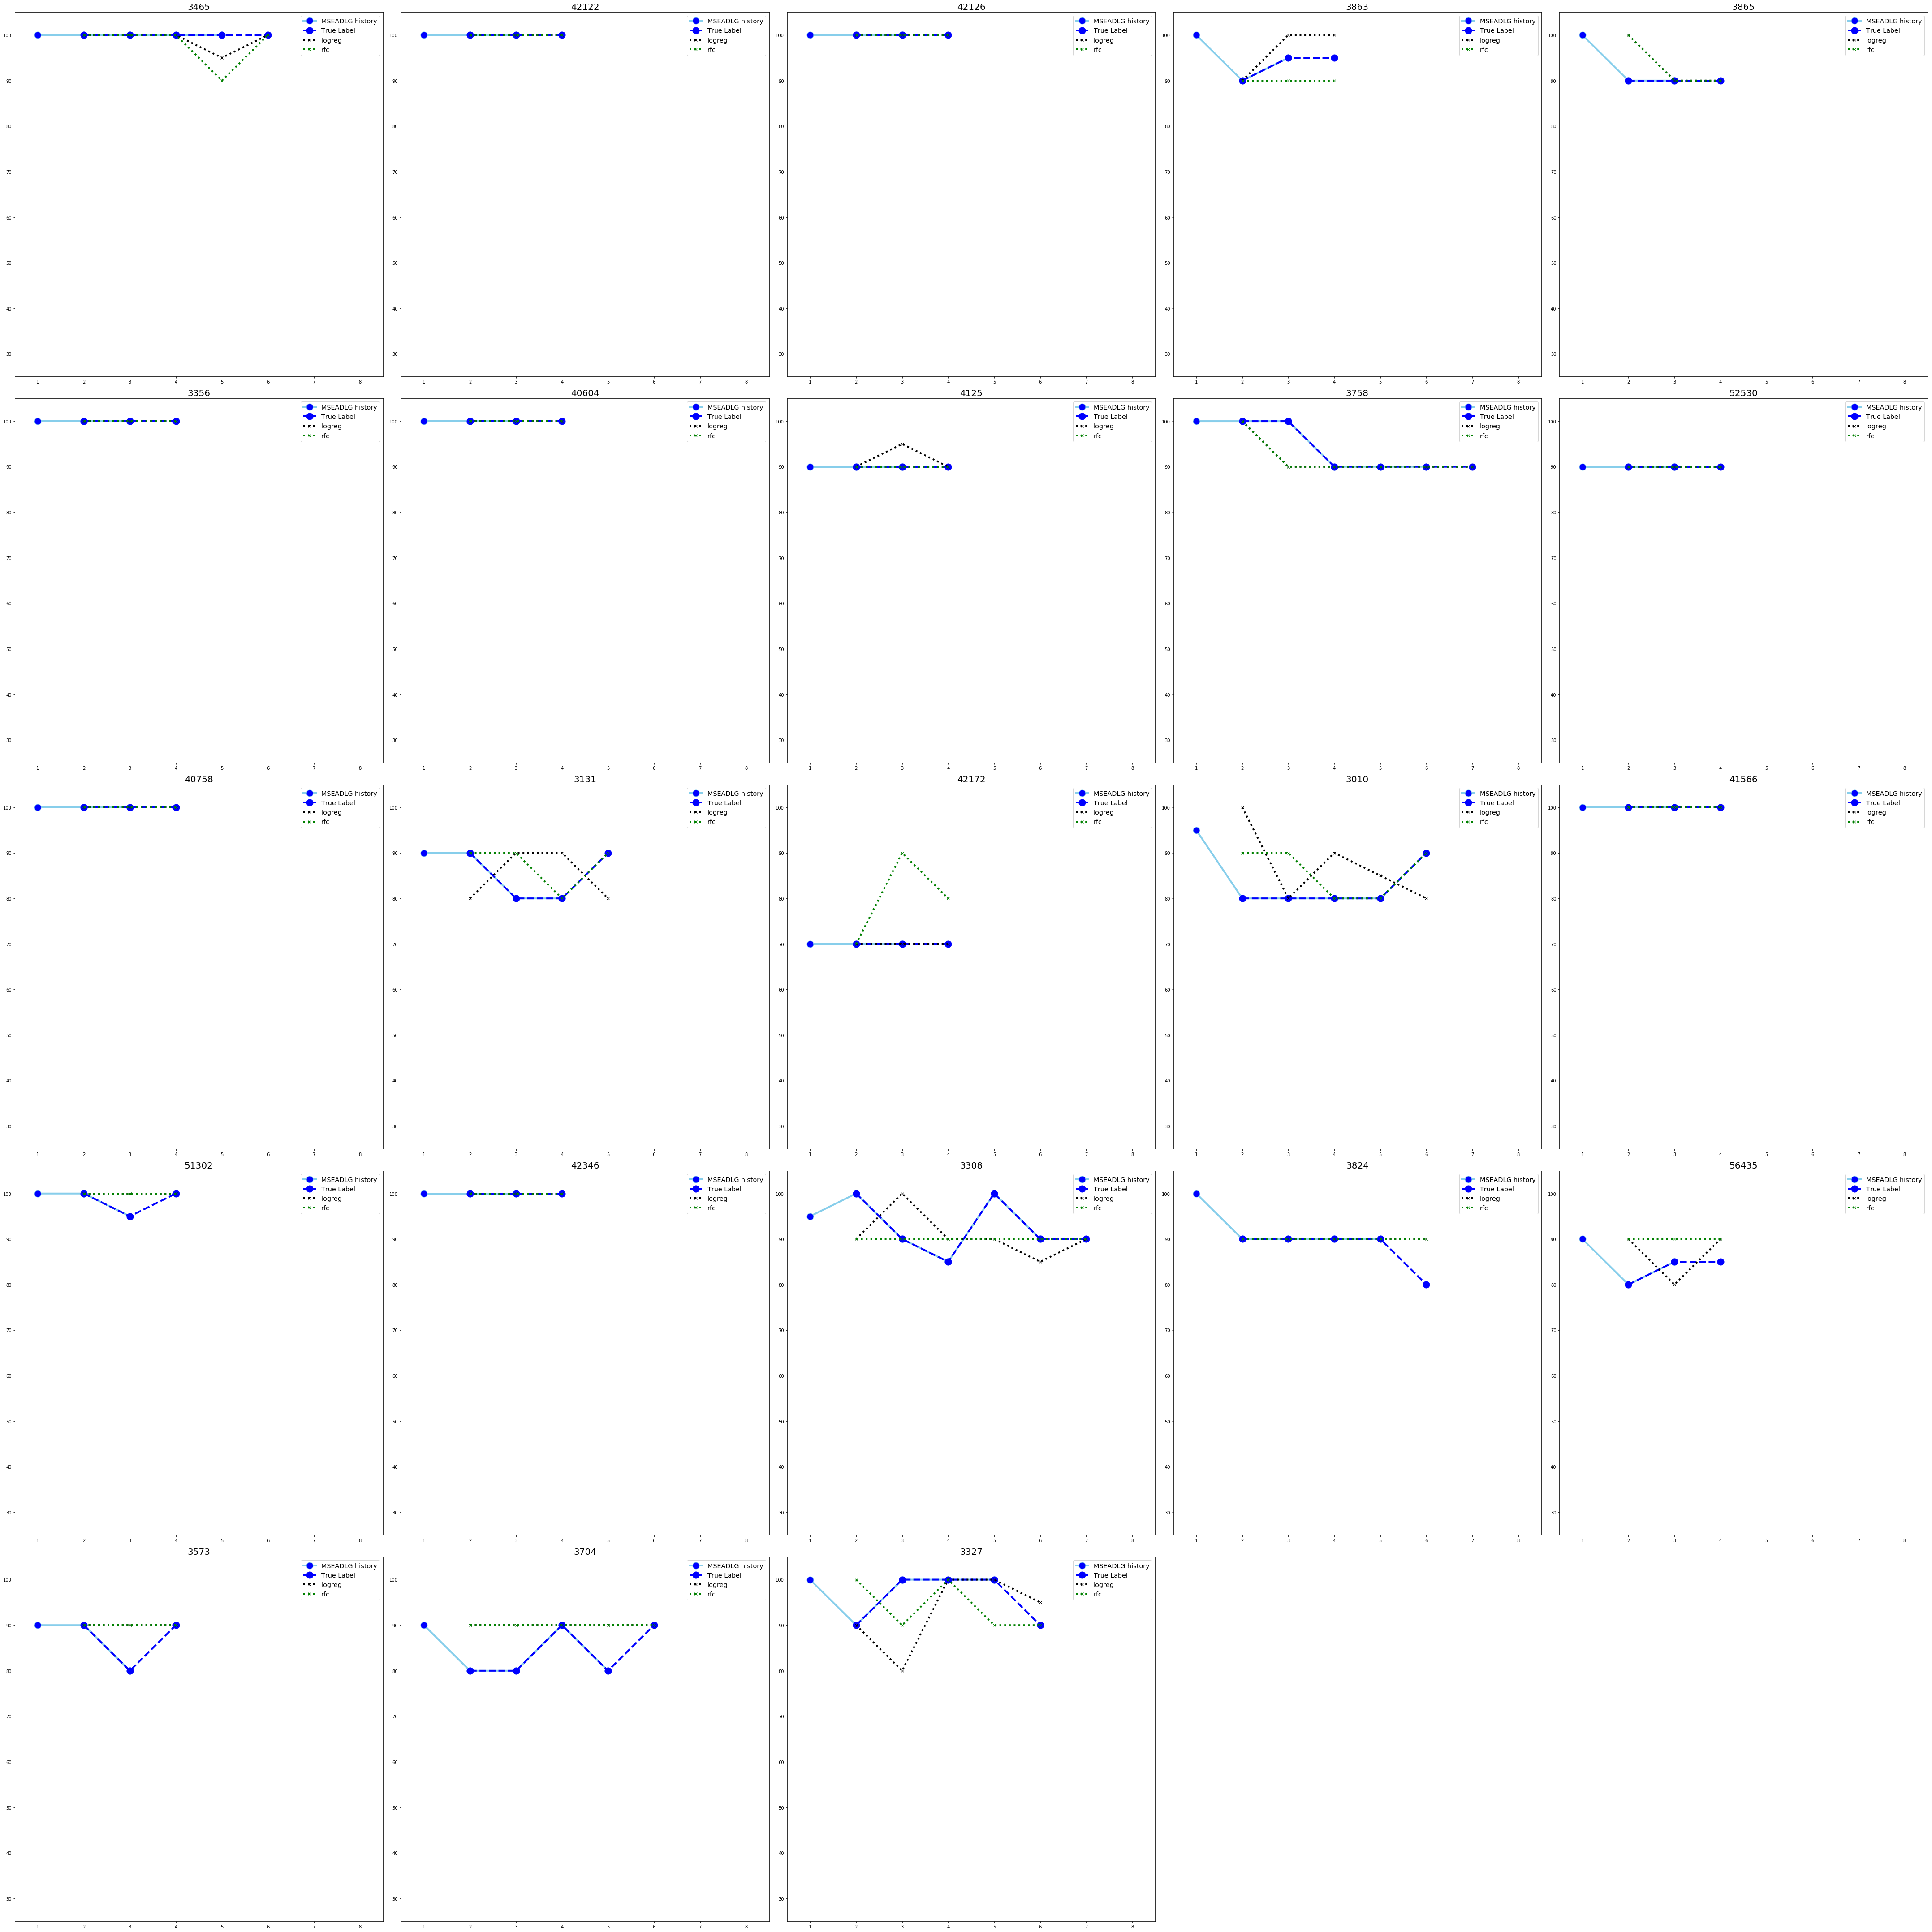

In [64]:
fig = plt.figure(figsize=(60,60))
num_pat=len(set(df_toPlot['PATNO']))
for pat,num in zip(list(set(df_toPlot['PATNO'])),range(1,num_pat+1)):
    df0=df_toPlot[df_toPlot['PATNO']==pat]
    ax = fig.add_subplot(5,5,num)
    ax.plot(df0['VISIT_ID'], df0['MSEADLG'],marker='o', markerfacecolor='blue', markersize=15, 
            color='skyblue', linewidth=4,label='MSEADLG history')
    ax.plot(df0['VISIT_ID_future'], df0['trueLabel'],marker='o',markersize=15,
            color='blue',linestyle='dashed',linewidth=4,label='True Label')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_logreg'], marker='x', 
            color='black', linewidth=4, linestyle='dotted', label='logreg')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_rfc'], marker='x', 
            color='green', linewidth=4, linestyle='dotted', label='rfc')
    ax.set_xlim([0.5, 8.5])
    ax.set_ylim([25, 105])
    ax.set_title(pat,fontdict={'fontsize':20})
    ax.legend(fontsize='x-large')
plt.tight_layout()
#fig.figure.suptitle('true labels vs predictions')
plt.savefig('/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/ML_predictions/predictions_graph_MSEADLG_123.png')
plt.show()     

### Features importance

In [ ]:
feature_importances = pd.DataFrame(rfc_TS.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures_TS=feature_importances[feature_importances.values>=0.01]
print(ImportantFeatures.values.sum())
ImportantFeatures_TS
#feature_importances